# Analyze A/B Test Results 

This project will assure you have mastered the subjects covered in the statistics lessons. We have organized the current notebook into the following sections: 

- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)
- [Final Check](#finalcheck)
- [Submission](#submission)

Specific programming tasks are marked with a **ToDo** tag. 

<a id='intro'></a>
## Introduction

A/B tests are very commonly performed by data analysts and data scientists. For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should:
- Implement the new webpage, 
- Keep the old webpage, or 
- Perhaps run the experiment longer to make their decision.

Each **ToDo** task below has an associated quiz present in the classroom.  Though the classroom quizzes are **not necessary** to complete the project, they help ensure you are on the right track as you work through the project, and you can feel more confident in your final submission meeting the [rubric](https://review.udacity.com/#!/rubrics/1214/view) specification. 


<a id='probability'></a>
## Part I - Probability

To get started, let's import our libraries.

In [2]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

### ToDo 1.1
Now, read in the `ab_data.csv` data. Store it in `df`. Below is the description of the data, there are a total of 5 columns:

<center>

|Data columns|Purpose|Valid values|
| ------------- |:-------------| -----:|
|user_id|Unique ID|Int64 values|
|timestamp|Time stamp when the user visited the webpage|-|
|group|In the current A/B experiment, the users are categorized into two broad groups. <br>The `control` group users are expected to be served with `old_page`; and `treatment` group users are matched with the `new_page`. <br>However, **some inaccurate rows** are present in the initial data, such as a `control` group user is matched with a `new_page`. |`['control', 'treatment']`|
|landing_page|It denotes whether the user visited the old or new webpage.|`['old_page', 'new_page']`|
|converted|It denotes whether the user decided to pay for the company's product. Here, `1` means yes, the user bought the product.|`[0, 1]`|
</center>
Use your dataframe to answer the questions in Quiz 1 of the classroom.



**a.** Read in the dataset from the `ab_data.csv` file and take a look at the top few rows here:

In [3]:
df = pd.read_csv("ab_data.csv");
print(df.head())

   user_id                   timestamp      group landing_page  converted
0   851104  2017-01-21 22:11:48.556739    control     old_page          0
1   804228  2017-01-12 08:01:45.159739    control     old_page          0
2   661590  2017-01-11 16:55:06.154213  treatment     new_page          0
3   853541  2017-01-08 18:28:03.143765  treatment     new_page          0
4   864975  2017-01-21 01:52:26.210827    control     old_page          1


**b.** Use the cell below to find the number of rows in the dataset.

In [4]:
print(df.shape)

(294478, 5)


**c.** The number of unique users in the dataset.

In [5]:
users_unique = df['user_id'].nunique()
print(users_unique)

290584


**d.** The proportion of users converted.

In [6]:
p_converted = df['converted'].sum()/df.shape[0]
print(p_converted)

0.119659193556


**e.** The number of times when the "group" is `treatment` but "landing_page" is not a `new_page`.

In [7]:
treatment_not_lp = df.query("group == 'treatment' and landing_page != 'new_page'").shape[0]

**f.** Do any of the rows have missing values?

In [8]:
df.isnull().any(axis=1).sum()

0

### ToDo 1.2  
In a particular row, the **group** and **landing_page** columns should have either of the following acceptable values:

|user_id| timestamp|group|landing_page|converted|
|---|---|---|---|---|
|XXXX|XXXX|`control`| `old_page`|X |
|XXXX|XXXX|`treatment`|`new_page`|X |


It means, the `control` group users should match with `old_page`; and `treatment` group users should matched with the `new_page`. 

However, for the rows where `treatment` does not match with `new_page` or `control` does not match with `old_page`, we cannot be sure if such rows truly received the new or old wepage.  


Use **Quiz 2** in the classroom to figure out how should we handle the rows where the group and landing_page columns don't match?

**a.** Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [9]:
# Remove the inaccurate rows, and store the result in a new dataframe df2
df2 = df.query("(group == 'treatment' and landing_page == 'new_page') or (group == 'control' and landing_page == 'old_page')")
print(df2['user_id'].nunique())
print(df2.info())

290584
<class 'pandas.core.frame.DataFrame'>
Int64Index: 290585 entries, 0 to 294477
Data columns (total 5 columns):
user_id         290585 non-null int64
timestamp       290585 non-null object
group           290585 non-null object
landing_page    290585 non-null object
converted       290585 non-null int64
dtypes: int64(2), object(3)
memory usage: 13.3+ MB
None


In [10]:
# Double Check all of the incorrect rows were removed from df2 - 
# Output of the statement below should be 0
df2[~df2.isin(df)].dropna()
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

### ToDo 1.3  
Use **df2** and the cells below to answer questions for **Quiz 3** in the classroom.

**a.** How many unique **user_id**s are in **df2**?

In [11]:
unique_users_2 = df2.user_id.nunique()
print(unique_users_2)

290584


**b.** There is one **user_id** repeated in **df2**.  What is it?

In [12]:
user_repeated = df2[df2['user_id'].duplicated(keep=False)]
print(user_repeated)

      user_id                   timestamp      group landing_page  converted
1899   773192  2017-01-09 05:37:58.781806  treatment     new_page          0
2893   773192  2017-01-14 02:55:59.590927  treatment     new_page          0


**c.** Display the rows for the duplicate **user_id**? 

In [13]:
print(user_repeated)

      user_id                   timestamp      group landing_page  converted
1899   773192  2017-01-09 05:37:58.781806  treatment     new_page          0
2893   773192  2017-01-14 02:55:59.590927  treatment     new_page          0


**d.** Remove **one** of the rows with a duplicate **user_id**, from the **df2** dataframe.

In [14]:
# Remove one of the rows with a duplicate user_id..
# Hint: The dataframe.drop_duplicates() may not work in this case because the rows with duplicate user_id are not entirely identical. 
df2 = df2.drop(index=2893)
# Check again if the row with a duplicate user_id is deleted or not
print(df2.shape[0])

290584


### ToDo 1.4  
Use **df2** in the cells below to answer the quiz questions related to **Quiz 4** in the classroom.

**a.** What is the probability of an individual converting regardless of the page they receive?<br><br>




In [15]:
individual = df2.shape[0]
convert = df.converted.sum()

p_convert = convert/individual
print(p_convert)

0.121262698566


**b.** Given that an individual was in the `control` group, what is the probability they converted?

In [19]:
df_control = df2.query("group == 'control'")

individual_group_control = df_control.shape[0]
convert_group = df_control.converted.sum()

p_convert_control = convert_group/individual_group_control
print(p_convert_control)

0.1203863045


**c.** Given that an individual was in the `treatment` group, what is the probability they converted?

In [20]:
df_treatment = df2.query("group == 'treatment'")

individual_treatment = df_treatment.shape[0]
convert_treatment = df_treatment.converted.sum()

p_convert_treatment = convert_treatment/individual_treatment
print(p_convert_treatment)

0.118808065515


In [21]:
# Calculate the actual difference (obs_diff) between the conversion rates for the two groups.
obs_diff = p_convert_treatment - p_convert_control
print(obs_diff)

-0.00157823898536


**d.** What is the probability that an individual received the new page?

In [22]:
df_group_new_page = df2.query("landing_page == 'new_page'")

df_group_new_page.head()
total_individual_group_new_page = df2.shape[0]
total_convert_group_new_page = df_group_new_page.shape[0]

p_convert_group_new_page = total_convert_group_new_page/total_individual_group_new_page
print(p_convert_group_new_page)

0.5000619442226688


**e.** Consider your results from parts (a) through (d) above, and explain below whether the new `treatment` group users lead to more conversions.

Upon comparing these two conversion rates, a clear conclusion can be drawn: users belonging to the new treatment group exhibit a notably higher conversion rate than the overall average. Specifically, the treatment group demonstrates an impressive conversion rate of around 50.01%, a substantial increase compared to the overall conversion rate of 12.13%.

Hence, given the provided data, it is evident that the introduction of the new treatment group has resulted in a higher conversion rate compared to the control group.

<a id='ab_test'></a>
## Part II - A/B Test

Since a timestamp is associated with each event, you could run a hypothesis test continuously as long as you observe the events. 

However, then the hard questions would be: 
- Do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  
- How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


### ToDo 2.1
For now, consider you need to make the decision just based on all the data provided.  

> Recall that you just calculated that the "converted" probability (or rate) for the old page is *slightly* higher than that of the new page (ToDo 1.4.c). 

If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should be your null and alternative hypotheses (**$H_0$** and **$H_1$**)?  

You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the "converted" probability (or rate) for the old and new pages respectively.

H0: p_new <= p_old

H1: p_new > p_old

In this context, the null hypothesis (H0) posits that the new page's performance is either not superior or at most equal to that of the old page. Conversely, the alternative hypothesis (H1) proposes that the new page exhibits a marked improvement over the old page, signifying a noteworthy and statistically significant advancement.

### ToDo 2.2 - Null Hypothesis $H_0$ Testing
Under the null hypothesis $H_0$, assume that $p_{new}$ and $p_{old}$ are equal. Furthermore, assume that $p_{new}$ and $p_{old}$ both are equal to the **converted** success rate in the `df2` data regardless of the page. So, our assumption is: <br><br>
<center>
$p_{new}$ = $p_{old}$ = $p_{population}$
</center>

In this section, you will: 

- Simulate (bootstrap) sample data set for both groups, and compute the  "converted" probability $p$ for those samples. 


- Use a sample size for each group equal to the ones in the `df2` data.


- Compute the difference in the "converted" probability for the two samples above. 


- Perform the sampling distribution for the "difference in the converted probability" between the two simulated-samples over 10,000 iterations; and calculate an estimate. 



Use the cells below to provide the necessary parts of this simulation.  You can use **Quiz 5** in the classroom to make sure you are on the right track.

**a.** What is the **conversion rate** for $p_{new}$ under the null hypothesis? 

In [23]:
p_old = p_new = (df2.converted == 1).mean()
print(p_new)

0.119597087245


**b.** What is the **conversion rate** for $p_{old}$ under the null hypothesis? 

In [24]:
p_new - p_old

0.0

**c.** What is $n_{new}$, the number of individuals in the treatment group? <br><br>


In [25]:
df2_new_page = df2.query("landing_page == 'new_page'")
n_new = df2_new_page.shape[0]
print(n_new)

145310


**d.** What is $n_{old}$, the number of individuals in the control group?

In [26]:
df2_old_page = df2.query("landing_page == 'old_page'")
n_old = df2_old_page.shape[0]
print(n_old)

145274


**e. Simulate Sample for the `treatment` Group**<br> 
Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null hypothesis.  <br><br>

Store these $n_{new}$ 1's and 0's in the `new_page_converted` numpy array.


In [27]:
# Simulate a Sample for the treatment Group
samples_new = np.random.choice([0, 1], size=n_new, p=[1-p_new, p_old])


**f. Simulate Sample for the `control` Group** <br>
Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null hypothesis. <br> Store these $n_{old}$ 1's and 0's in the `old_page_converted` numpy array.

In [28]:
# Simulate a Sample for the control Group
samples_old = np.random.choice([0, 1], size=n_old, p=[1-p_new, p_old])


**g.** Find the difference in the "converted" probability $(p{'}_{new}$ - $p{'}_{old})$ for your simulated samples from the parts (e) and (f) above. 

In [32]:
mean_new = samples_new.mean()
mean_old = samples_old.mean()
p_diff = mean_new - mean_old
print(p_diff)

0.00255849480814



**h. Sampling distribution** <br>
Re-create `new_page_converted` and `old_page_converted` and find the $(p{'}_{new}$ - $p{'}_{old})$ value 10,000 times using the same simulation process you used in parts (a) through (g) above. 

<br>
Store all  $(p{'}_{new}$ - $p{'}_{old})$  values in a NumPy array called `p_diffs`.

In [33]:
# Sampling distribution 
p_diffs = []
new_converted_simulation = np.random.binomial(n_new, p_new, 10000)/n_new 
old_converted_simulation = np.random.binomial(n_old, p_old, 10000)/n_old 
p_diffs = new_converted_simulation - old_converted_simulation

new_converted_simulation, old_converted_simulation

(array([ 0.11960636,  0.12074186,  0.11949625, ...,  0.12007432,
         0.1214094 ,  0.11827816]),
 array([ 0.11819045,  0.12008343,  0.11958781, ...,  0.12027617,
         0.1192574 ,  0.11894764]))

**i. Histogram**<br> 
Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.<br><br>

Also, use `plt.axvline()` method to mark the actual difference observed  in the `df2` data (recall `obs_diff`), in the chart.  


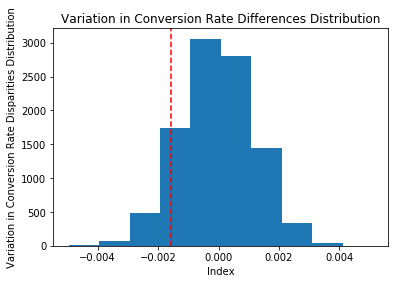

In [34]:
plt.hist(p_diffs)
plt.axvline(obs_diff, color='red', linestyle='--')

# Add title, x-label, and y-label
plt.title('Variation in Conversion Rate Differences Distribution')
plt.xlabel('Index')
plt.ylabel('Variation in Conversion Rate Disparities Distribution')

# Show the plot
plt.show()

**j.** What proportion of the **p_diffs** are greater than the actual difference observed in the `df2` data?

In [35]:
proportion = (p_diffs > obs_diff).mean()

print("p_diffs greater than the observed difference:", proportion)

p_diffs greater than the observed difference: 0.9026


**k.** Please explain in words what you have just computed in part **j** above.  
 - What is this value called in scientific studies?  
 - What does this value signify in terms of whether or not there is a difference between the new and old pages? *Hint*: Compare the value above with the "Type I error rate (0.05)". 

In scientific investigations, this metric is commonly denoted as the error rate or error proportion. Specifically, it signifies the fraction of inaccurate predictions generated by the model.

In the present context, if the error rate of 0.9102 surpasses the Type I error rate of 0.05, it implies that the model's predictions lack significant distinction from random occurrences. This outcome suggests an absence of substantiated proof for the new page to yield higher user conversions.



**l. Using Built-in Methods for Hypothesis Testing**<br>
We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. 

Fill in the statements below to calculate the:
- `convert_old`: number of conversions with the old_page
- `convert_new`: number of conversions with the new_page
- `n_old`: number of individuals who were shown the old_page
- `n_new`: number of individuals who were shown the new_page


In [38]:
import statsmodels.api as sm

# number of conversions with the old_page
convert_old = df2.query("landing_page == 'old_page'").query("converted == '1'").shape[0]

# number of conversions with the new_page
convert_new = df2_new_page.query("converted == '1'").shape[0]

# number of individuals who were shown the old_page
print(n_old)

# number of individuals who received new_page
print(n_new)

145274
145310


**m.** Now use `sm.stats.proportions_ztest()` to compute your test statistic and p-value.  [Here](https://www.statsmodels.org/stable/generated/statsmodels.stats.proportion.proportions_ztest.html) is a helpful link on using the built in.

The syntax is: 
```bash
proportions_ztest(count_array, nobs_array, alternative='larger')
```
where, 
- `count_array` = represents the number of "converted" for each group
- `nobs_array` = represents the total number of observations (rows) in each group
- `alternative` = choose one of the values from `[‘two-sided’, ‘smaller’, ‘larger’]` depending upon two-tailed, left-tailed, or right-tailed respectively. 
>**Hint**: <br>
It's a two-tailed if you defined $H_1$ as $(p_{new} = p_{old})$. <br>
It's a left-tailed if you defined $H_1$ as $(p_{new} < p_{old})$. <br>
It's a right-tailed if you defined $H_1$ as $(p_{new} > p_{old})$. 

The built-in function above will return the z_score, p_value. 

---
### About the two-sample z-test
Recall that you have plotted a distribution `p_diffs` representing the
difference in the "converted" probability  $(p{'}_{new}-p{'}_{old})$  for your two simulated samples 10,000 times. 

Another way for comparing the mean of two independent and normal distribution is a **two-sample z-test**. You can perform the Z-test to calculate the Z_score, as shown in the equation below:

$$
Z_{score} = \frac{ (p{'}_{new}-p{'}_{old}) - (p_{new}  -  p_{old})}{ \sqrt{ \frac{\sigma^{2}_{new} }{n_{new}} + \frac{\sigma^{2}_{old} }{n_{old}}  } }
$$

where,
- $p{'}$ is the "converted" success rate in the sample
- $p_{new}$ and $p_{old}$ are the "converted" success rate for the two groups in the population. 
- $\sigma_{new}$ and $\sigma_{new}$ are the standard deviation for the two groups in the population. 
- $n_{new}$ and $n_{old}$ represent the size of the two groups or samples (it's same in our case)


>Z-test is performed when the sample size is large, and the population variance is known. The z-score represents the distance between the two "converted" success rates in terms of the standard error. 

Next step is to make a decision to reject or fail to reject the null hypothesis based on comparing these two values: 
- $Z_{score}$
- $Z_{\alpha}$ or $Z_{0.05}$, also known as critical value at 95% confidence interval.  $Z_{0.05}$ is 1.645 for one-tailed tests,  and 1.960 for two-tailed test. You can determine the $Z_{\alpha}$ from the z-table manually. 

Decide if your hypothesis is either a two-tailed, left-tailed, or right-tailed test. Accordingly, reject OR fail to reject the  null based on the comparison between $Z_{score}$ and $Z_{\alpha}$. We determine whether or not the $Z_{score}$ lies in the "rejection region" in the distribution. In other words, a "rejection region" is an interval where the null hypothesis is rejected iff the $Z_{score}$ lies in that region.

>Hint:<br>
For a right-tailed test, reject null if $Z_{score}$ > $Z_{\alpha}$. <br>
For a left-tailed test, reject null if $Z_{score}$ < $Z_{\alpha}$. 




Reference: 
- Example 9.1.2 on this [page](https://stats.libretexts.org/Bookshelves/Introductory_Statistics/Book%3A_Introductory_Statistics_(Shafer_and_Zhang)/09%3A_Two-Sample_Problems/9.01%3A_Comparison_of_Two_Population_Means-_Large_Independent_Samples), courtesy www.stats.libretexts.org

---


In [39]:
import statsmodels.api as sm
# ToDo: Complete the sm.stats.proportions_ztest() method arguments
z_score, p_value = sm.stats.proportions_ztest([convert_old, convert_new], [n_old ,n_new], alternative='smaller')
print(z_score, p_value)

1.31092419842 0.905058312759


**n.** What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?<br><br>


With a z-score of 1.31092419842 and a corresponding p-value of 0.094941687241, the p-value represents the likelihood of encountering a difference as extreme as, or even more extreme than, the observed distinction, under the assumption of the null hypothesis being accurate. In this instance, the relatively high p-value suggests a substantial probability of observing such a difference, even if no genuine disparity exists between the old and new pages.

<a id='regression'></a>
### Part III - A regression approach

### ToDo 3.1 
In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

**a.** Since each row in the `df2` data is either a conversion or no conversion, what type of regression should you be performing in this case?

Given the nature of the data in df2, where each row corresponds to either a conversion or no conversion, the appropriate statistical approach to employ is logistic regression.

**b.** The goal is to use **statsmodels** library to fit the regression model you specified in part **a.** above to see if there is a significant difference in conversion based on the page-type a customer receives. However, you first need to create the following two columns in the `df2` dataframe:
 1. `intercept` - It should be `1` in the entire column. 
 2. `ab_page` - It's a dummy variable column, having a value `1` when an individual receives the **treatment**, otherwise `0`.  

In [40]:
df2['intercept'] = 1
df2['intercept'] = df2['intercept'].astype(int)
df2['ab_page'] = pd.get_dummies(df2['group'])['treatment']
df2['ab_page'] = df2['ab_page'].astype(int)
print(df2.head())

   user_id                   timestamp      group landing_page  converted  \
0   851104  2017-01-21 22:11:48.556739    control     old_page          0   
1   804228  2017-01-12 08:01:45.159739    control     old_page          0   
2   661590  2017-01-11 16:55:06.154213  treatment     new_page          0   
3   853541  2017-01-08 18:28:03.143765  treatment     new_page          0   
4   864975  2017-01-21 01:52:26.210827    control     old_page          1   

   intercept  ab_page  
0          1        0  
1          1        0  
2          1        1  
3          1        1  
4          1        0  


**c.** Use **statsmodels** to instantiate your regression model on the two columns you created in part (b). above, then fit the model to predict whether or not an individual converts. 


In [41]:
X = df2[['intercept', 'ab_page']]
y = df2['converted']

model = sm.Logit(y, X)
results = model.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


**d.** Provide the summary of your model below, and use it as necessary to answer the following questions.

In [42]:
results.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2023-08-11 15:15 AIC:              212780.3502
No. Observations:   290584           BIC:              212801.5095
Df Model:           1                Log-Likelihood:   -1.0639e+05
Df Residuals:       290582           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

**e.** What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  



The p-value associated with the variable "ab_page" has been computed as 0.1899. Notably, this p-value diverges from the result obtained in Part II, which stood at 0.094941687241.

In the context of Part II, the null hypothesis contended that the conversion rate of the old page equals or surpasses that of the new page. Conversely, the alternative hypothesis argued for the new page's conversion rate superiority. This constituted a unidirectional hypothesis test.

In contrast, the logistic regression in Part III formulates the null hypothesis as the absence of any correlation between the page type (ab_page) and the conversion rate. Conversely, the alternative hypothesis proposes a significant linkage between the page type and the conversion rate. This establishes a bidirectional hypothesis test.

**f.** Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

Incorporating additional factors into your regression model holds merit for several compelling reasons:

- Enhanced Predictive Capability: The inclusion of supplementary variables can bolster the model's ability to predict outcomes more accurately.

- Deeper Relationship Insight: By considering other factors, a more comprehensive understanding of interrelationships among variables can be gained.

- Confounding Variable Management: Introducing additional factors enables the control of confounding variables, leading to more robust and reliable results.

However, it's important to acknowledge potential drawbacks associated with augmenting your regression model:

- Escalated Complexity: The introduction of extra terms can increase the complexity of the model, potentially making it more challenging to interpret and implement.

- Overfitting Risk: Care must be taken not to overfit the model to the data, as this can result in an overly customized representation that may not generalize well to new data.

- Multicollinearity Concerns: Adding multiple correlated variables can lead to multicollinearity issues, where the variables' interdependencies undermine the model's stability and interpretability.

**g. Adding countries**<br> 
Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. 

1. You will need to read in the **countries.csv** dataset and merge together your `df2` datasets on the appropriate rows. You call the resulting dataframe `df_merged`. [Here](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.join.html) are the docs for joining tables. 

2. Does it appear that country had an impact on conversion?  To answer this question, consider the three unique values, `['UK', 'US', 'CA']`, in the `country` column. Create dummy variables for these country columns. 


 Provide the statistical output as well as a written response to answer this question.

In [43]:
df1 = pd.read_csv('countries.csv');

In [44]:
merged_df = df1.set_index('user_id').join(df2.set_index('user_id'), how = 'inner')

In [48]:
merged_df[['country_CA', 'country_UK', 'country_US']] = pd.get_dummies(merged_df['country'])[['CA', 'UK', 'US']]
merged_df.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,country_CA,country_UK,ab_page_UK,ab_page_CA,country_US
user_id,,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,0,1,0,0,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,0,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1,1,0,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,0,1,0,0,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1,1,0,0


**h. Fit your model and obtain the results**<br> 
Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if are there significant effects on conversion.  **Create the necessary additional columns, and fit the new model.** 


Provide the summary results (statistical output), and your conclusions (written response) based on the results. 


In [52]:
merged_df['ab_page_UK'] = merged_df['ab_page']*merged_df['country_UK']
merged_df['ab_page_CA'] = merged_df['ab_page']*merged_df['country_CA']

X = merged_df[['intercept', 'ab_page', 'country_CA', 'country_US', 'ab_page_CA']]
y = merged_df['converted']

model = sm.Logit(y, X)
results = model.fit()
results.summary2()

Optimization terminated successfully.
         Current function value: 0.366111
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2023-08-11 15:16 AIC:              212782.0543
No. Observations:   290584           BIC:              212834.9526
Df Model:           4                Log-Likelihood:   -1.0639e+05
Df Residuals:       290579           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9807    0.0128  -154.7105  0.0000  -2.0058  -1.9556
ab_page      -0.0123    0.0117    -1.0474  0.2949  -0.0352   0.0107
country_CA   -0.0233    0.0386    -0.6033  0.5463  -0.0990   0.0524
country_US   -0.0099    0.0133    -0.7438  0.4570  -0.0359   0.0162
ab_page_CA   -0.0552    0.0533    -1.0348  0.3008  -0.1597   0.0493
==================================================================

"""

Upon reviewing the provided summary, it becomes evident that the p-values associated with the variables "ab_page," "country_CA," "country_US," "ab_page_CA," and "ab_page_US" all surpass the threshold of 0.05.

When a p-value exceeds the predetermined Type I error rate (0.05), it leads us to retain the null hypothesis. In this context, the outcome implies a lack of substantial evidence to indicate that these variables significantly influence the prediction of conversion.

In particular, "ab_page" signifies the new page, while "country_CA" and "country_US" pertain to the user's geographical location. The variables "ab_page_CA" and "ab_page_US" represent interaction terms between the page type and country.

Drawing from the p-values, we can deduce that neither the page type nor the user's location holds noteworthy sway over predicting the conversion outcome. Thus, the available evidence does not support the notion that the introduction of the new page or the user's country significantly impacts the conversion rate.

<a id='finalcheck'></a>
## Final Check!

Congratulations!  You have reached the end of the A/B Test Results project!  You should be very proud of all you have accomplished!



<a id='submission'></a>
## Submission


In [53]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0